In [8]:
orgData<- read.csv("data/Allelectronics.csv",fileEncoding="GBK")

head(orgData)

age,income,student,credit_rating,buys_computer
<=30,high,no,fair,no
<=30,high,no,excellent,no
31…40,high,no,fair,yes
>40,medium,no,fair,yes
>40,low,yes,fair,yes
>40,low,yes,excellent,no


In [14]:
#其中age的1代表“<=30”，2代表“31…40”，3代表“>40”，并且为因子变量
#进行该编码的目的是C50不能处理"..."和"<="之类的特殊字符
orgData$age<-unclass(as.factor(orgData$age))

summary(orgData)

      age       income  student   credit_rating buys_computer
 Min.   :1   high  :4   no :7   excellent:6     no :5        
 1st Qu.:1   low   :4   yes:7   fair     :8     yes:9        
 Median :2   medium:6                                        
 Mean   :2                                                   
 3rd Qu.:3                                                   
 Max.   :3                                                   

##   Section 1: C50算法

In [15]:
#1.建立C50模型
##建模
library(C50)

In [16]:
#调整树大小的主要变量
#事前剪枝设置
#minCases结点如果要被分割，要求的最小样本量，值越大，模型就越小
#winnow事先是否筛选变量，设置为T的话，模型一般比较小
#事后剪枝设置
##CF置信因子越小，要求模型的置信度越高，模型就越小
  #affects the way that error rates are estimated and hence the severity of pruning; 
  #values smaller than the default (25%) cause more of the initial tree to be pruned, 
  #while larger values result in less pruning.
#noGlobalPruning是否进行第二轮基于全局性的事后剪枝操作，设置为F的话，模型一般比较小
  #disables this second pruning component and generally results in larger 
  #decision tees and rulesets. 
  #Turning off global pruning can be beneficial for some applications, 
  #particularly when rulesets are generated.
tc<-C5.0Control(minCases = 2,winnow=F,CF=0.99,noGlobalPruning=T)

tc

$subset
[1] TRUE

$bands
[1] 0

$winnow
[1] FALSE

$noGlobalPruning
[1] TRUE

$CF
[1] 0.99

$minCases
[1] 2

$fuzzyThreshold
[1] FALSE

$sample
[1] 0

$earlyStopping
[1] TRUE

$label
[1] "outcome"

$seed
[1] 1842

In [17]:
model <- C5.0(buys_computer ~age+income+student+credit_rating,data=orgData,
              trials=1,rules=F,control =tc )

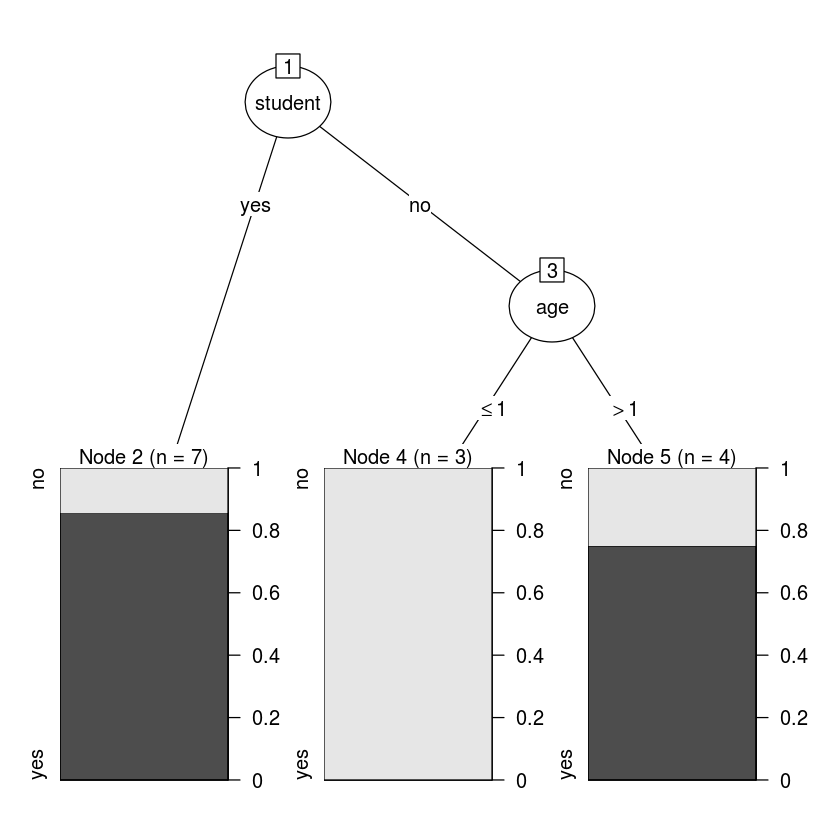

In [18]:
#图形展示
plot(model)

In [19]:
#生成规则
rule <- C5.0(buys_computer ~age+income+student+credit_rating,data=orgData,
              trials=1,rules=T)
summary( rule )


Call:
C5.0.formula(formula = buys_computer ~ age + income + student +
 credit_rating, data = orgData, trials = 1, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Mon Nov  7 12:20:00 2016
-------------------------------

Class specified by attribute `outcome'

Read 14 cases (5 attributes) from undefined.data

Rules:

Rule 1: (3, lift 2.2)
	age <= 1
	student = no
	->  class no  [0.800]

Rule 2: (7/1, lift 1.2)
	student = yes
	->  class yes  [0.778]

Rule 3: (9/2, lift 1.1)
	age > 1
	->  class yes  [0.727]

Default class: yes


Evaluation on training data (14 cases):

	        Rules     
	  ----------------
	    No      Errors

	     3    2(14.3%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	     3     2    (a): class no
	           9    (b): class yes


	Attribute usage:

	 85.71%	age
	 71.43%	student


Time: 0.0 secs


##   Section 2: CART算法(分类树)

In [20]:
#1.建立CART模型
##建模
#CART在R中的实现
#rpart包中有针对CART决策树算法提供的函数，比如rpart函数
#以及用于剪枝的prune函数
#rpart函数的基本形式：rpart(formula,data,subset,na.action=na.rpart,method.parms,control,...)
library(rpart)

In [22]:
#1.建立CART模型
#1.1 设置前向剪枝的条件
tc <- rpart.control(minsplit=1,minbucket=1,maxdepth=10,xval=5,cp=0.005)
## rpart.control对树进行一些设置  
## minsplit是最小分支节点数，这里指大于等于5，那么该节点会继续分划下去，否则停止  
## minbucket：树中叶节点包含的最小样本数  
## maxdepth：决策树最大深度 
## xval:交叉验证的次数
## cp全称为complexity parameter，指某个点的复杂度，对每一步拆分,模型的拟合优度必须提高的程度
tc

$minsplit
[1] 1

$minbucket
[1] 1

$cp
[1] 0.005

$maxcompete
[1] 4

$maxsurrogate
[1] 5

$usesurrogate
[1] 2

$surrogatestyle
[1] 0

$maxdepth
[1] 10

$xval
[1] 5

In [23]:
#1.2 建模
rpart.mod=rpart(buys_computer ~age+income+student+credit_rating,data=orgData, 
                parms = list(split = "gini"),method="class",control=tc)
summary(rpart.mod)

Call:
rpart(formula = buys_computer ~ age + income + student + credit_rating, 
    data = orgData, method = "class", parms = list(split = "gini"), 
    control = tc)
  n= 14 

     CP nsplit rel error xerror      xstd
1 0.300      0       1.0    1.0 0.3585686
2 0.100      2       0.4    1.4 0.3741657
3 0.005      6       0.0    0.8 0.3380617

Variable importance
          age credit_rating        income       student 
           37            29            17            16 

Node number 1: 14 observations,    complexity param=0.3
  predicted class=yes  expected loss=0.3571429  P(node) =1
    class counts:     5     9
   probabilities: 0.357 0.643 
  left son=2 (7 obs) right son=3 (7 obs)
  Primary splits:
      student       splits as  LR,      improve=1.2857140, (0 missing)
      age           < 1.5 to the left,  improve=0.9174603, (0 missing)
      credit_rating splits as  LR,      improve=0.4285714, (0 missing)
      income        splits as  LRR,     improve=0.2285714, (0 missing)
 

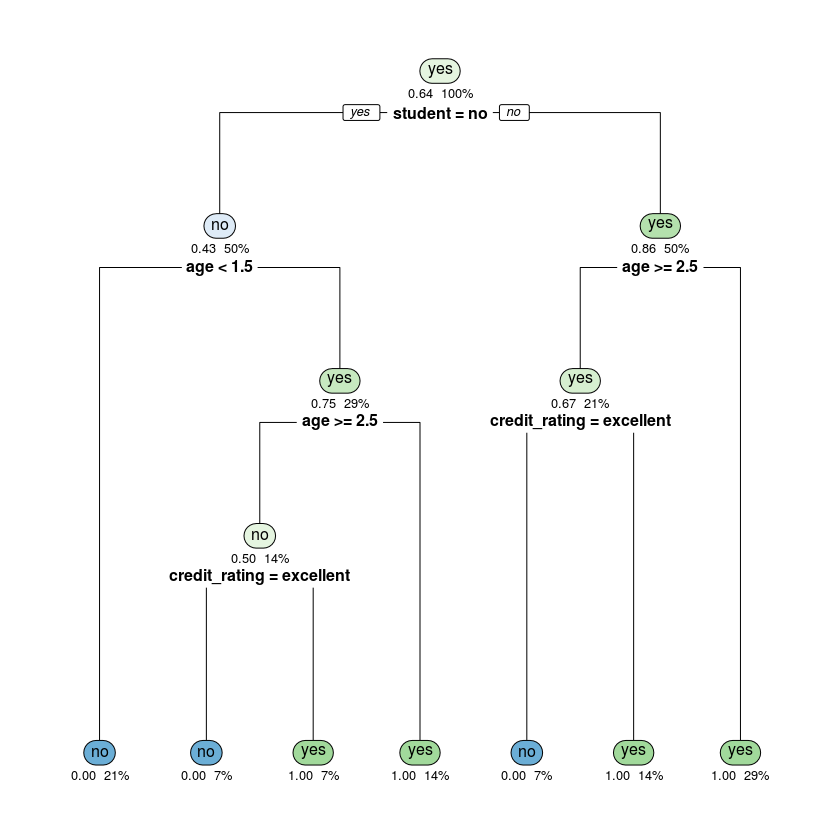

In [25]:
#1.3图形展示
library(rpart.plot)
rpart.plot(rpart.mod,branch=1, extra=106, under=TRUE, faclen=0,
           cex=0.8)

,CP,nsplit,rel error,xerror,xstd
1,0.300,0,1.0,1.0,0.3585686
2,0.100,2,0.4,1.4,0.3741657
3,0.005,6,0.0,0.8,0.3380617


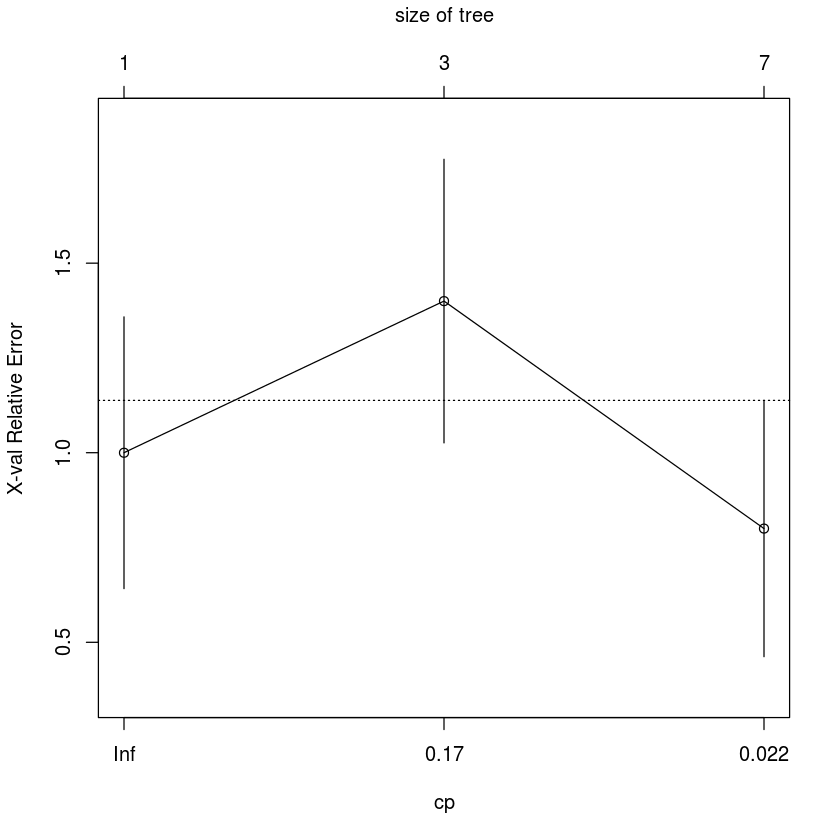

In [27]:
#2.cart剪枝方法
#cp是每次分割对应的复杂度系数
rpart.mod$cp
plotcp(rpart.mod)

,CP,nsplit,rel error,xerror,xstd
1,0.300,0,1.0,1.0,0.3585686
2,0.100,2,0.4,1.4,0.3741657
3,0.005,6,0.0,0.8,0.3380617


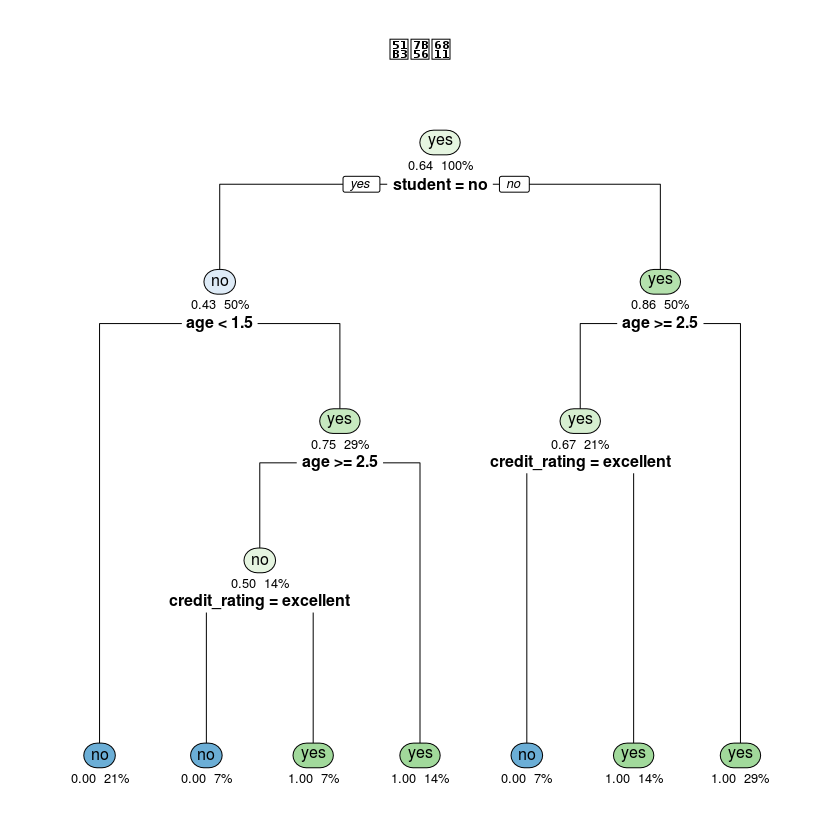

In [29]:
#prune函数可以实现最小代价复杂度剪枝法，对于CART的结果，每个节点均输出一个对应的cp
#prune函数通过设置cp参数来对决策树进行修剪,cp为复杂度系数
## 我们可以用下面的办法选择具有最小xerror的cp的办法：  
rpart.mod.pru<-prune(rpart.mod, cp= rpart.mod$cptable[which.min(rpart.mod$cptable[,"xerror"]),"CP"]) 
rpart.mod.pru$cp

rpart.plot(rpart.mod.pru,branch=1, extra=106, under=TRUE, faclen=0,
           cex=0.8, main="决策树")